In [57]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())
import pandas as pd
from scipy import interpolate

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_quad, elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, save_fig, scatter_2d, scatter_3d,
                              fig_config, set_axes_equal)
from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, get_imcolors, export_rect_idx)

In [23]:
set_colorblind()
%config InlineBackend.figure_format = 'retina'

In [127]:
# input data

polarization = 'tm'
f = 60
origin = [-25.28, 17.25]
edge_length = 20
APD_av = 5.75
TPD_av = 6.36

# APD distribution

In [128]:
# load surface data

df = load_ear_data(polarization, f, surface='front')
df = clean_df(df)
xyz = export_pcd(df)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

# postprocessing on the surface of the model

E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)
pcd.estimate_normals()
n = np.asarray(pcd.normals)
APD = np.abs(Sx.real * n[:, 0] + Sy.real * n[:, 1] + Sz.real * n[:, 2])

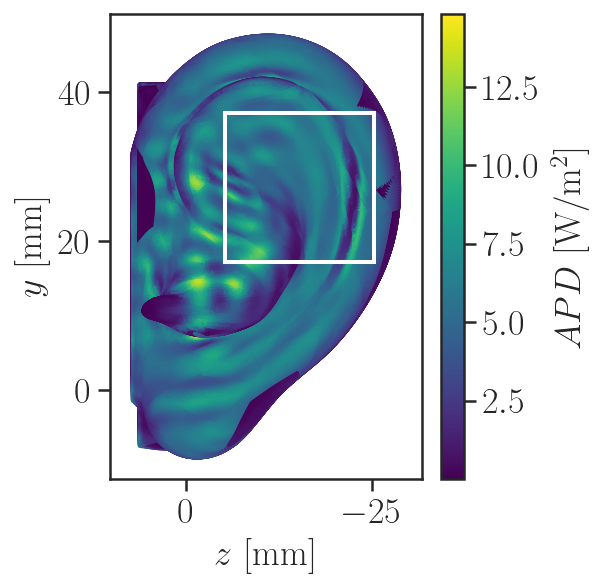

In [129]:
fig_config(latex=True, scaler=2, text_size=18)
label = '$APD$ [W/m$^{2}$]'
fig, ax = scatter_2d({'$z$ [mm]': xyz[:, 2],
                      '$y$ [mm]': xyz[:, 1],
                      label: APD},
                     s=0.5,
                     figsize=(2.950 * 1.5, 2.950 * 1.5))
patch_rect = Rectangle(origin, edge_length, edge_length, fc='None', lw=2)
ax.add_patch(patch_rect)
ax.invert_xaxis()

# SAR distribution

In [130]:
# load model data

fname_block = os.path.join('data', f'loss_3D_ear_{f}GHz_{polarization.upper()}_front.txt')
df = (pd.read_csv(fname_block, names=['x [mm]', 'y [mm]', 'z [mm]', 'Pl [W/m^3]'],
                  header=None, delim_whitespace=True, skiprows=[0, 1])
      [lambda x: (x['Pl [W/m^3]'] != 0.0)])
df.reset_index(drop=True, inplace=True)
xyz = export_pcd(df)
Pl = df['Pl [W/m^3]'].to_numpy()
tissue_density = 1049

# postprocessing

SAR = Pl / tissue_density

In [ ]:
skip = 1
fig_config(latex=True, text_size=18, scaler=2)
fig = plt.figure()
ax = plt.axes(projection ='3d')
cs = ax.scatter(xyz[::skip, 2], xyz[::skip, 0], xyz[::skip, 1],
                c=SAR[::skip],
                cmap='viridis',
                s=0.5)
cbar = fig.colorbar(cs, shrink=0.55, pad=0)
cbar.ax.set_ylabel('$SAR$ [W/kg]')
cbar.ax.yaxis.labelpad = 12
ax.set(xlabel='$z$ [mm]', ylabel='$x$ [mm]',
       xticks=[10, -10, -30],
       yticks=[50, 70, 90],
       zticks=[-5, 20, 45])
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('$y$ [mm]', rotation=90)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.zaxis.labelpad = 12

ax.view_init(10, 70)
ax = set_axes_equal(ax)
fig.tight_layout();